In [996]:

import pandas.io.sql as sqlio
import psycopg2
import plotly.graph_objects as go
import pandas as pd
import datetime
import calmap
from plotly.subplots import make_subplots
from pathlib import Path
import json
from numpy import quantile
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt, mpld3
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
#https://pythonhosted.org/calmap/

In [1006]:
def get_properties():
    props = {}
    separator = "="
            
    with open('./database.properties') as file:
        for line in file: 
            if separator in line:
                name, value = line.split(separator, 1)
                props[name.strip()] = value.strip()
    return props

In [1007]:
class Database:
    def __init__(self):
        db_prop = get_properties()
        self.username = db_prop.get('username')
        self.password = db_prop.get('password')
        self.host = db_prop.get('host')
        self.port = db_prop.get('port')
        #self.database = db_prop.get('database')
        
    def connect(self, database):
        connection = psycopg2.connect(user=self.username,
                                      password=self.password,
                                      host=self.host,
                                      port=self.port,
                                      database=database)
        return connection, connection.cursor()
    
    def execute_query(self, query, database="habit"):
        result = None
        conn, cursor = None, None
        try:
            conn, cursor = self.connect(database)
            result = sqlio.read_sql_query(query, conn)
        except(Exception, psycopg2.Error) as error:
            print("Error while executing sql", error)
        finally:
            if conn:
                cursor.close()
                conn.close()
            return result
    
    def read_habits(self):
        query = 'SELECT "name", "date" FROM public.task order by date desc'
        return self.execute_query(query)
    def read_meditation(self):
        query = 'select * from meditation inner join task on meditation.task_fk = task.id order by date desc'
        return self.execute_query(query)    
    def read_fit(self):
        query = 'select * from exercise inner join task on exercise.task_fk = task.id order by date desc'
        return self.execute_query(query)
    def read_old_fit(self):
        query = 'select fit_activity.calories, fit_activity.heart_rate, fit_activity.duration, fit_activity.distance, activity.note,\
            activity.date from fit_activity inner join activity on activity_fk =activity.id '
        return self.execute_query(query, "Habits")
          
#select fit_activity.calories, fit_activity.heart_rate, fit_activity.duration, fit_activity.distance, activity.note, activity.date, activity.name
#from fit_activity
#FULL OUTER JOIN activity on activity_fk =activity.id

In [1008]:

db = Database()
habits = db.read_habits()
meditation = db.read_meditation()
fit_20 =db.read_old_fit()
fit_20 = fit_20[["date", "note", "calories", "distance","duration"]]
fit_20 = fit_20.rename(columns={"note": "name"})
fit_21= db.read_fit()


In [1009]:
meditation

id              type  duration  task_fk    id      name        date
0     2341  Daily Meditation       697     3750  3750  Meditate  2021-12-06
1     2342        Self Timer       660     3513  3513  Meditate  2021-11-01
2     2343        Self Timer       660     3505  3505  Meditate  2021-10-31
3     2344        Self Timer       660     3476  3476  Meditate  2021-10-26
4     2345  Daily Meditation      1219     3467  3467  Meditate  2021-10-25
...    ...               ...       ...      ...   ...       ...         ...
1637  1404      Meditation 2       624     1731  1731  Meditate  2018-11-06
1638  2577      Meditation 1       498     1731  1731  Meditate  2018-11-06
1639  2578      Meditation 2       624     1731  1731  Meditate  2018-11-06
1640  1871      Meditation 1       498     1731  1731  Meditate  2018-11-06
1641  2339      Meditation 1       498     1731  1731  Meditate  2018-11-06

[1642 rows x 7 columns]

In [1010]:
start_date_19 = datetime.date(2019 ,1,1)
start_date_20 = datetime.date(2020,1,1)
start_date_21 = datetime.date(2021,1,1)
start_date_22 = datetime.date(2022,1,1)


fit_20 = fit_20.sort_values(by=["date"])
fit_20.duration = fit_20.duration.astype(str)
fit_20.duration = pd.to_timedelta(fit_20.duration).astype('timedelta64[m]')
fit_20["distance"] = fit_20["distance"]/1609
fit_19 = fit_20[(fit_20.date>start_date_19) &  (fit_20.date<start_date_20)].copy()
fit_20 = fit_20[(fit_20.date>start_date_20)].copy()



fit_21 = fit_21[["date", "name","average_heart_rate", "calories", "steps", "distance", "duration", "timestamp"]]
fit_21.date = pd.to_datetime(fit_21.date).dt.date
fit_21 = fit_21[fit_21.date>start_date_21].copy()
fit_21.duration = fit_21.duration/60000
fit_21 = fit_21.drop_duplicates()
fit_21 = fit_21[np.invert([(fit_21["name"]=="Run") & (fit_21["duration"]>90)])[0]]
fit_21 = fit_21.sort_values(by=["date"])


In [1011]:
meditation

id              type  duration  task_fk    id      name        date
0     2341  Daily Meditation       697     3750  3750  Meditate  2021-12-06
1     2342        Self Timer       660     3513  3513  Meditate  2021-11-01
2     2343        Self Timer       660     3505  3505  Meditate  2021-10-31
3     2344        Self Timer       660     3476  3476  Meditate  2021-10-26
4     2345  Daily Meditation      1219     3467  3467  Meditate  2021-10-25
...    ...               ...       ...      ...   ...       ...         ...
1637  1404      Meditation 2       624     1731  1731  Meditate  2018-11-06
1638  2577      Meditation 1       498     1731  1731  Meditate  2018-11-06
1639  2578      Meditation 2       624     1731  1731  Meditate  2018-11-06
1640  1871      Meditation 1       498     1731  1731  Meditate  2018-11-06
1641  2339      Meditation 1       498     1731  1731  Meditate  2018-11-06

[1642 rows x 7 columns]

In [1012]:
meditation = meditation[["date", "duration", "type"]]
meditation.date = pd.to_datetime(meditation.date).dt.date
meditation_19 = meditation[(meditation.date > start_date_20) &  (meditation.date < start_date_21)]
meditation = meditation[(meditation.date > start_date_21) &  (meditation.date < start_date_22)]
meditation["duration"] = pd.to_timedelta(meditation.duration, unit="s").astype('timedelta64[m]')
meditation = meditation.drop_duplicates()
meditation_19 = meditation_19.drop_duplicates()

C:\Users\zeusg\Envs\habit\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1013]:
meditation_19

date  duration                                               type
445   2020-12-27       660                                         Self Timer
449   2020-12-15       599                                   Daily Meditation
452   2020-12-10      5091  A Conversation with Jason Rosenthal and Miles ...
455   2020-12-10       660                                         Self Timer
456   2020-12-10        55                                          Moment 37
...          ...       ...                                                ...
1307  2020-02-04       616                                         Course 272
1310  2020-01-27       603                                         Course 266
1313  2020-01-21       550                                         Course 255
1315  2020-01-21       608                                         Course 207
1320  2020-01-07       622                                         Course 154

[234 rows x 3 columns]

In [1014]:
meditation

date  duration              type
0    2021-12-06      11.0  Daily Meditation
1    2021-11-01      11.0        Self Timer
2    2021-10-31      11.0        Self Timer
3    2021-10-26      11.0        Self Timer
4    2021-10-25      20.0  Daily Meditation
..          ...       ...               ...
430  2021-01-08      20.0  Daily Meditation
433  2021-01-07      20.0  Daily Meditation
436  2021-01-06      10.0  Daily Meditation
439  2021-01-05      20.0  Daily Meditation
442  2021-01-04      20.0  Daily Meditation

[127 rows x 3 columns]

In [1015]:
meditation

date  duration              type
0    2021-12-06      11.0  Daily Meditation
1    2021-11-01      11.0        Self Timer
2    2021-10-31      11.0        Self Timer
3    2021-10-26      11.0        Self Timer
4    2021-10-25      20.0  Daily Meditation
..          ...       ...               ...
430  2021-01-08      20.0  Daily Meditation
433  2021-01-07      20.0  Daily Meditation
436  2021-01-06      10.0  Daily Meditation
439  2021-01-05      20.0  Daily Meditation
442  2021-01-04      20.0  Daily Meditation

[127 rows x 3 columns]

In [1016]:
habits["frequency"] = 1
habits.date = pd.to_datetime(habits.date).dt.date
habits = habits[(habits.date >start_date_21) & (habits.date < start_date_22)]
habits = habits.drop_duplicates()

In [1017]:
habits

name        date  frequency
12              Run  2021-12-15          1
13    Clean Patrick  2021-12-15          1
14         Walk Dog  2021-12-15          1
15      Programming  2021-12-15          1
16              Cat  2021-12-15          1
...             ...         ...        ...
1787      Plan Week  2021-01-04          1
1788       Meditate  2021-01-04          1
1789    Programming  2021-01-04          1
1790            Cat  2021-01-04          1
1791  Clean Patrick  2021-01-04          1

[1780 rows x 3 columns]

In [1018]:
sdate = datetime.date(2021,1,1) 
edate = datetime.date(2021,12,31) 
date_range = pd.date_range(sdate,edate-datetime.timedelta(days=1),freq='d')

df = pd.DataFrame()
df["date"] = date_range
df["date"] = pd.to_datetime(date_range).date

key_habits = ["Meditate", "Run", "Yoga",  "Weights",  "Programming", "Class", "Notes",  "Andrew", "Read", "Study", "Walk Dog", "Garbage", "Plan Week", "Dishes", "Clean House"]

for key in key_habits:
    habit = habits[habits.name.str.contains(key)]
    df[key] = 0
    for date in habit.date:
        ind = df.index[df["date"] == date]
        df.at[ind.values[0], key] = 1
df = df.rename(columns = {"Andrew": "Group Study"})
basket = df.copy()

In [1019]:
df['Day'] = pd.to_datetime(df['date']).dt.day_name()
df['Month'] = pd.to_datetime(df['date']).dt.month
df

date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0    2021-01-01         0    0     0        0            0      0      0   
1    2021-01-02         0    0     0        0            0      0      0   
2    2021-01-03         0    0     0        0            0      0      0   
3    2021-01-04         1    0     0        0            1      0      1   
4    2021-01-05         1    0     1        0            0      0      0   
..          ...       ...  ...   ...      ...          ...    ...    ...   
359  2021-12-26         0    0     0        0            0      0      0   
360  2021-12-27         0    0     0        0            0      0      0   
361  2021-12-28         0    0     0        0            0      0      0   
362  2021-12-29         0    0     0        0            0      0      0   
363  2021-12-30         0    0     0        0            0      0      0   

     Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0              0     0      0         0        0          0       0   
1              0     0      0         0        0          0       0   
2              0     0      0         0        0          0       0   
3              0     1      1         1        0          1       0   
4              1     0      0         1        1          0       1   
..           ...   ...    ...       ...      ...        ...     ...   
359            0     0      0         0        0          0       0   
360            0     0      0         0        0          0       0   
361            0     0      0         0        0          0       0   
362            0     0      0         0        0          0       0   
363            0     0      0         0        0          0       0   

     Clean House        Day  Month  
0              0     Friday      1  
1              0   Saturday      1  
2              0     Sunday      1  
3              0     Monday      1  
4              0    Tuesday      1  
..           ...        ...    ...  
359            0     Sunday     12  
360            0     Monday     12  
361            0    Tuesday     12  
362            0  Wednesday     12  
363            0   Thursday     12  

[364 rows x 18 columns]

In [1022]:
basket = basket.drop(["date"], axis=1)

In [1023]:
basket

Meditate  Run  Yoga  Weights  Programming  Class  Notes  Group Study  \
0           0    0     0        0            0      0      0            0   
1           0    0     0        0            0      0      0            0   
2           0    0     0        0            0      0      0            0   
3           1    0     0        0            1      0      1            0   
4           1    0     1        0            0      0      0            1   
..        ...  ...   ...      ...          ...    ...    ...          ...   
359         0    0     0        0            0      0      0            0   
360         0    0     0        0            0      0      0            0   
361         0    0     0        0            0      0      0            0   
362         0    0     0        0            0      0      0            0   
363         0    0     0        0            0      0      0            0   

     Read  Study  Walk Dog  Garbage  Plan Week  Dishes  Clean House  
0       0      0         0        0          0       0            0  
1       0      0         0        0          0       0            0  
2       0      0         0        0          0       0            0  
3       1      1         1        0          1       0            0  
4       0      0         1        1          0       1            0  
..    ...    ...       ...      ...        ...     ...          ...  
359     0      0         0        0          0       0            0  
360     0      0         0        0          0       0            0  
361     0      0         0        0          0       0            0  
362     0      0         0        0          0       0            0  
363     0      0         0        0          0       0            0  

[364 rows x 15 columns]

In [1024]:
frequent_itemsets = apriori(basket, min_support=0.07, use_colnames=True)

In [1055]:
frequent_itemsets.sort_values(by=["support"])

support                                    itemsets
17  0.071429                            (Read, Meditate)
51  0.071429                    (Walk Dog, Run, Garbage)
43  0.076923           (Programming, Walk Dog, Meditate)
35  0.076923                           (Walk Dog, Study)
57  0.082418  (Group Study, Walk Dog, Garbage, Meditate)
49  0.082418                (Walk Dog, Dishes, Meditate)
18  0.085165                           (Study, Meditate)
46  0.087912            (Group Study, Garbage, Meditate)
14  0.087912                     (Programming, Meditate)
22  0.090659                          (Dishes, Meditate)
41  0.090659                    (Run, Garbage, Meditate)
25  0.096154                              (Run, Garbage)
34  0.096154                            (Walk Dog, Read)
54  0.096154              (Class, Walk Dog, Group Study)
30  0.098901                        (Class, Group Study)
53  0.098901               (Group Study, Walk Dog, Yoga)
7   0.101648                                     (Study)
48  0.101648             (Walk Dog, Plan Week, Meditate)
56  0.101648      (Group Study, Walk Dog, Run, Meditate)
27  0.107143                         (Group Study, Yoga)
29  0.107143                     (Programming, Walk Dog)
21  0.107143                       (Plan Week, Meditate)
44  0.109890                 (Class, Walk Dog, Meditate)
15  0.109890                           (Class, Meditate)
39  0.109890                (Group Study, Run, Meditate)
38  0.109890                          (Walk Dog, Dishes)
37  0.109890                       (Walk Dog, Plan Week)
6   0.109890                                      (Read)
55  0.112637            (Group Study, Walk Dog, Garbage)
52  0.118132                     (Class, Walk Dog, Yoga)
50  0.118132                (Group Study, Walk Dog, Run)
33  0.120879                      (Group Study, Garbage)
42  0.120879                  (Walk Dog, Yoga, Meditate)
10  0.120879                                 (Plan Week)
3   0.126374                               (Programming)
11  0.126374                                    (Dishes)
23  0.126374                          (Group Study, Run)
26  0.131868                               (Class, Yoga)
13  0.140110                            (Yoga, Meditate)
47  0.140110               (Walk Dog, Garbage, Meditate)
20  0.175824                         (Garbage, Meditate)
31  0.181319                           (Class, Walk Dog)
36  0.184066                         (Walk Dog, Garbage)
28  0.195055                            (Walk Dog, Yoga)
40  0.200549                   (Walk Dog, Run, Meditate)
45  0.206044           (Group Study, Walk Dog, Meditate)
4   0.211538                                     (Class)
24  0.219780                             (Walk Dog, Run)
16  0.219780                     (Group Study, Meditate)
12  0.230769                             (Run, Meditate)
9   0.233516                                   (Garbage)
2   0.244505                                      (Yoga)
1   0.260989                                       (Run)
32  0.291209                     (Group Study, Walk Dog)
5   0.310440                               (Group Study)
19  0.428571                        (Walk Dog, Meditate)
0   0.497253                                  (Meditate)
8   0.653846                                  (Walk Dog)

In [1028]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

antecedents                        consequents  \
0                  (Run)                         (Meditate)   
1             (Meditate)                              (Run)   
2                 (Yoga)                         (Meditate)   
3             (Meditate)                             (Yoga)   
4          (Programming)                         (Meditate)   
..                   ...                                ...   
179  (Garbage, Meditate)            (Group Study, Walk Dog)   
180        (Group Study)      (Walk Dog, Garbage, Meditate)   
181           (Walk Dog)   (Group Study, Garbage, Meditate)   
182            (Garbage)  (Group Study, Walk Dog, Meditate)   
183           (Meditate)   (Group Study, Walk Dog, Garbage)   

     antecedent support  consequent support   support  confidence      lift  \
0              0.260989            0.497253  0.230769    0.884211  1.778191   
1              0.497253            0.260989  0.230769    0.464088  1.778191   
2              0.244505            0.497253  0.140110    0.573034  1.152399   
3              0.497253            0.244505  0.140110    0.281768  1.152399   
4              0.126374            0.497253  0.087912    0.695652  1.398991   
..                  ...                 ...       ...         ...       ...   
179            0.175824            0.291209  0.082418    0.468750  1.609670   
180            0.310440            0.140110  0.082418    0.265487  1.894846   
181            0.653846            0.087912  0.082418    0.126050  1.433824   
182            0.233516            0.206044  0.082418    0.352941  1.712941   
183            0.497253            0.112637  0.082418    0.165746  1.471500   

     leverage  conviction  
0    0.100992    4.341908  
1    0.100992    1.378979  
2    0.018529    1.177487  
3    0.018529    1.051881  
4    0.025072    1.651884  
..        ...         ...  
179  0.031216    1.334195  
180  0.038922    1.170694  
181  0.024937    1.043639  
182  0.034303    1.227023  
183  0.026408    1.063660  

[184 rows x 9 columns]

In [1030]:
rules.lift.max()

2.8629961587708066

In [1037]:
rules[ (rules['lift'] >= 1.6) &
       (rules['confidence'] >= 0.8) ].sort_values(by=["confidence"])

antecedents           consequents  antecedent support  \
161            (Group Study, Run)  (Walk Dog, Meditate)            0.126374   
12                        (Study)            (Meditate)            0.101648   
112                   (Plan Week)  (Walk Dog, Meditate)            0.120879   
156  (Group Study, Walk Dog, Run)            (Meditate)            0.118132   
54             (Group Study, Run)            (Meditate)            0.126374   
0                           (Run)            (Meditate)            0.260989   
18                    (Plan Week)            (Meditate)            0.120879   
60                (Walk Dog, Run)            (Meditate)            0.219780   
108         (Walk Dog, Plan Week)            (Meditate)            0.109890   
66                 (Run, Garbage)            (Meditate)            0.096154   

     consequent support   support  confidence      lift  leverage  conviction  
161            0.428571  0.101648    0.804348  1.876812  0.047488    2.920635  
12             0.497253  0.085165    0.837838  1.684934  0.034620    3.100275  
112            0.428571  0.101648    0.840909  1.962121  0.049843    3.591837  
156            0.497253  0.101648    0.860465  1.730438  0.042907    3.603022  
54             0.497253  0.109890    0.869565  1.748739  0.047050    3.854396  
0              0.497253  0.230769    0.884211  1.778191  0.100992    4.341908  
18             0.497253  0.107143    0.886364  1.782521  0.047035    4.424176  
60             0.497253  0.200549    0.912500  1.835083  0.091263    5.745683  
108            0.497253  0.101648    0.925000  1.860221  0.047005    6.703297  
66             0.497253  0.090659    0.942857  1.896133  0.042847    8.798077

In [1040]:
corrMatrix = basket[["Meditate", "Run", "Yoga", "Weights", "Programming", "Class", "Read"]].corr()
corrMatrix


Meditate       Run      Yoga   Weights  Programming     Class  \
Meditate     1.000000  0.459924  0.086223  0.168999     0.150918  0.023027   
Run          0.459924  1.000000  0.011236 -0.023341     0.056376  0.059796   
Yoga         0.086223  0.011236  1.000000  0.060807    -0.100944  0.456600   
Weights      0.168999 -0.023341  0.060807  1.000000     0.087826 -0.045903   
Programming  0.150918  0.056376 -0.100944  0.087826     1.000000 -0.176756   
Class        0.023027  0.059796  0.456600 -0.045903    -0.176756  1.000000   
Read         0.107341 -0.048795 -0.056822 -0.005315     0.130731  0.076107   

                 Read  
Meditate     0.107341  
Run         -0.048795  
Yoga        -0.056822  
Weights     -0.005315  
Programming  0.130731  
Class        0.076107  
Read         1.000000

In [1049]:
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=corrMatrix.columns,
        y=corrMatrix.columns,
        z=corrMatrix.values.tolist(),
    ))
fig.update_layout(
    title="Correlation Of Habits",
)
fig.write_html("./webpage/heatmap.html")
fig.show()

In [1020]:
totals = df.sum()
totals

C:\Users\zeusg\AppData\Local\Temp/ipykernel_35628/1399528012.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Meditate                                                     181
Run                                                           95
Yoga                                                          89
Weights                                                       10
Programming                                                   46
Class                                                         77
Notes                                                         17
Group Study                                                  113
Read                                                          40
Study                                                         37
Walk Dog                                                     238
Garbage                                                       85
Plan Week                                                     44
Dishes                                                        46
Clean House                                                   23
Day            FridaySatu

In [967]:


program_total = totals["Programming"]
class_total = totals["Class"]
group_total = totals["Group Study"]
reading_total = totals["Read"]
misc_total = totals["Study"] + totals ["Notes"]

weights_total = totals["Weights"]
yoga_total = totals["Yoga"]
run_total = totals["Run"]
meditation_daily = len(meditation[meditation["type"].str.contains("Daily")])
meditation_self = len(meditation[meditation["type"].str.contains("Self")])
meditation_total = totals["Meditate"]
meditation_other = meditation_total - (meditation_daily + meditation_self)

exercise_total = weights_total + yoga_total + run_total
learning_total = program_total + class_total + group_total + reading_total + misc_total
all_total = exercise_total+ learning_total+ meditation_total



In [968]:
meditation_19

date  duration                                               type
445   2020-12-27       660                                         Self Timer
449   2020-12-15       599                                   Daily Meditation
452   2020-12-10      5091  A Conversation with Jason Rosenthal and Miles ...
455   2020-12-10       660                                         Self Timer
456   2020-12-10        55                                          Moment 37
...          ...       ...                                                ...
1307  2020-02-04       616                                         Course 272
1310  2020-01-27       603                                         Course 266
1313  2020-01-21       550                                         Course 255
1315  2020-01-21       608                                         Course 207
1320  2020-01-07       622                                         Course 154

[234 rows x 3 columns]

In [969]:
meditation_19
meditation_daily_19 = len(meditation_19[meditation_19["type"].str.contains("Daily")])
meditation_self_19 = len(meditation_19[meditation_19["type"].str.contains("Self")])



In [971]:
program_19 = 102
reading_19 = 78
math_19 = 18
run_19 = 74
yoga_19 = 64
weights_19 =10
meditation_19_total=213
meditation_daily_19 = len(meditation_19[meditation_19["type"].str.contains("Daily")])
meditation_self_19 = len(meditation_19[meditation_19["type"].str.contains("Self")])
meditation_other_19 = meditation_19_total -meditation_daily_19-meditation_self_19

learning_total_19 = program_19+reading_19+math_19
exercise_total_19 = run_19+yoga_19+weights_19
all_19 = learning_total_19+exercise_total_19+meditation_19_total


In [981]:
fig =go.Figure(go.Sunburst(
    labels=["All: 2020", "Learning", "Exercise", "Meditation",  "Programming", "Reading", "Math", "Weights", "Yoga", "Running", "Timer", "Guided", "Other"],
    parents=["", "All: 2020", "All: 2020", "All: 2020",  "Learning", "Learning",  "Learning", "Exercise", "Exercise", "Exercise", "Meditation", "Meditation", "Meditation"],
    values=[all_19, learning_total_19, exercise_total_19, meditation_19_total, program_19, reading_19, math_19, weights_19, yoga_19, run_19, meditation_self_19, meditation_daily_19, meditation_other_19],
    textinfo= 'label+value',
    branchvalues="total",
))
fig.write_html("./webpage/sunburst_19.html")
fig.show()

In [979]:
fig =go.Figure(go.Sunburst(
    labels=["All: 2021", "Exercise", "Learning", "Meditation", "Timer", "Guided", "Other", "Programming", "Class", "Group Study", "Reading", "Misc", "Weights", "Yoga", "Running"],
    parents=["", "All: 2021", "All: 2021", "All: 2021", "Meditation", "Meditation", "Meditation",  "Learning", "Learning", "Learning", "Learning", "Learning", "Exercise", "Exercise", "Exercise"],
    values=[all_total, exercise_total, learning_total, meditation_total, meditation_self, meditation_daily, meditation_other, program_total, class_total, group_total, reading_total, misc_total, weights_total, yoga_total, run_total],
    textinfo= 'label+value',
    branchvalues="total",
))
#fig.update_layout(
#    autosize=False,
#    width=800,
#    height=800,)
fig.write_html("./webpage/sunburst.html")
fig.show()

In [634]:
props = get_properties()
directory = Path(props['fit_file_location'])
fit_heart_rates = {}
#fit_calories = {}

for _,exercise in fit_21.iterrows():
    heart_rate_file_name = "heart_rate-" + str(exercise.date)+".json"
    heart_rate_path = directory.joinpath('Physical Activity/'+heart_rate_file_name)
    
    #calories_file_name = "calories-" + str(exercise.date)+".json"
    #calories_path = directory.joinpath('Physical Activity/'+calories_file_name)
    
    duration = pd.to_timedelta(exercise.duration, unit="m")
    start = pd.to_datetime(str(exercise.date) + " " + str(exercise.timestamp))
    end = start + duration
    #Heart Rate
    with open(heart_rate_path) as heart_rate_file:
        heart_rate = json.load(heart_rate_file)
        exercise_heart_rate = [heart_rate_data for heart_rate_data in heart_rate 
                               if (pd.to_datetime(heart_rate_data["dateTime"]) > start) &
                               (pd.to_datetime(heart_rate_data["dateTime"]) < end)]
        try:
            heart_rate_df = pd.DataFrame(exercise_heart_rate)
            heart_rate_df["bpm"] =  heart_rate_df.value.apply(lambda x: x.get("bpm"))
            fit_heart_rates[str(exercise.date) + " " + str(exercise["name"])] = heart_rate_df
        except:
            fit_21 = fit_21[(fit_21.date != exercise.date) & (fit_21.name != exercise.name)]
            print("failed on " + str(exercise.date) + " " + str(exercise["name"]))
            
    #Calories
    #with open(calories_path) as calories_file:
    #    calories = json.load(calories_file)
    #    exercise_calories = [calories_data for calories_data in calories 
    #                           if (pd.to_datetime(calories_data["dateTime"]) > start) &
    #                           (pd.to_datetime(calories_data["dateTime"]) < end)]
    #    try:
    #        calories_df = pd.DataFrame(exercise_calories)
    #        fit_calories[str(exercise.date) + " " + str(exercise["name"])] = calories_df
    #    except:
    #        fit_21 = fit_21[(fit_21.date != exercise.date) & (fit_21.name != exercise.name)]
    #        print("failed on " + str(exercise.date) + " " + str(exercise["name"]))
    
    


KeyboardInterrupt: 

In [642]:
df.head(2)

date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0  2021-01-01         0    0     0        0            0      0      0   
1  2021-01-02         0    0     0        0            0      0      0   

   Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0            0     0      0         0        0          0       0   
1            0     0      0         0        0          0       0   

   Clean House day_of_week  month       Day  Month  
0            0      Friday      1    Friday      1  
1            0    Saturday      1  Saturday      1

In [671]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
day_df = df.groupby(by=["Day"]).sum()
day_df = day_df.reset_index()
day_df["Day"] = day_df["Day"].astype(cat_type)
day_df = day_df.sort_values(by=["Day"])
day_df

Day  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
1     Monday        35   17    12        2            7      6      2   
5    Tuesday        38   25     9        1            9     14      5   
6  Wednesday        34   17    15        3           10     15      4   
4   Thursday        23   14    14        2            6     11      2   
0     Friday        27   14    13        0            7     11      4   
2   Saturday        16    4    11        0            6     11      0   
3     Sunday         8    4    15        2            1      9      0   

   Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
1            7     5      8        37        2         22      11   
5           23     6      9        35       34         20       3   
6           34    10      9        40        8          2      11   
4           25     4      2        35        1          0       0   
0           21     8      7        37       32          0       5   
2            3     3      2        29        8          0       8   
3            0     4      0        25        0          0       8   

   Clean House  Month  
1           14    339  
5            1    340  
6            1    342  
4            0    344  
0            0    334  
2            0    335  
3            7    336

In [1053]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Meditate"],
        name="Meditate",
        legendgroup = '1',
    ))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"] + day_df["Weights"] + day_df["Run"], 
        name="Exercise",
        legendgroup = '1',
    ))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"] + day_df["Class"] + day_df["Notes"]+ day_df["Read"] + day_df["Study"] + day_df["Group Study"],
        name="Study",
        legendgroup = '1',
    ))
fig.update_layout(
    title="Habit Daily Frequency",
    yaxis=dict(
        title_text="Frequency",
        ),
    xaxis=dict(
        title_text="Day Of The Week",
    ),
    
)

fig.write_html("./webpage/habitMetaFrequency.html")
fig.show()

In [1054]:
fig = make_subplots(
    rows = 1, 
    cols=2,
    specs=[[{}, {}]],
    subplot_titles=("Exercise", "Education"))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"],
        name="Yoga",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Weights"],
        name="Weights",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Run"],
        name="Run",
        legendgroup = '1',
    ),row=1,col=1)


fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"],
        name="Programming",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Class"],
        name="Class",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Read"],
        name="Read",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Group Study"],
        name="Group Study",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Notes"] + day_df["Study"],
        name="Misc",
        legendgroup = '2',
    ),row=1,col=2)

fig.update_layout(
    title="Habit Daily Detailed Frequency",
)
fig['layout']['xaxis']['title']='Days Of The Week'
fig['layout']['xaxis2']['title']='Days Of The Week'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig.write_html("./webpage/habitFrequency.html")

fig.show()

In [696]:
fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{"colspan": 2}, None],
           [{}, {}]],
    subplot_titles=("Meta Categoreis","Exercise", "Education"))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Meditate"],
        name="Meditate",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"] + day_df["Weights"] + day_df["Run"], 
        name="Exercise",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"] + day_df["Class"] + day_df["Notes"]+ day_df["Read"] + day_df["Study"] + day_df["Group Study"],
        name="Study",
        legendgroup = '1',
    ),row=1,col=1)

fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"],
        name="Yoga",
        legendgroup = '2',
    ),row=2,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Weights"],
        name="Weights",
        legendgroup = '2',
    ),row=2,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Run"],
        name="Run",
        legendgroup = '2',
    ),row=2,col=1)


fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"],
        name="Programming",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Class"],
        name="Class",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Read"],
        name="Read",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Group Study"],
        name="Group Study",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Notes"] + day_df["Study"],
        name="Misc",
        legendgroup = '3',
    ),row=2,col=2)

fig.update_layout(
    title="Habit Daily Frequency",
    legend_tracegroupgap = 170,
    autosize=False,
    width=1200,
    height=800,
)
fig['layout']['xaxis']['title']='Days Of The Week'
fig['layout']['xaxis2']['title']='Days Of The Week'
fig['layout']['xaxis3']['title']='Days Of The Week'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig['layout']['yaxis3']['title']='Frequency'
fig.write_html("./webpage/habitFrequency.html")

fig.show()

In [11]:
fig = go.Figure([go.Bar(
    x = df.date,
    y = df.Meditate,
)])

fig.show()

date  Meditate  Run  Yoga  Weights  Programming  Class  Group Study  \
0  2021-01-01         0    0     0        0            0      0            0   

   Read  Study  Walk Dog  Garbage  Plan Week  Dishes  Clean House  
0     0      0         0        0          0       0            0

In [13]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Run,
    name = "Run",
))
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Yoga,
    name = "Yoga",
))
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Weights,
    name = "Weights",
))

fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = df.date,
    y = df["Group Study"],
    name = "Group",
))
fig.show()

In [852]:
cal_df = df.copy()
cal_df["date"] = pd.to_datetime(df["date"])
cal_df = cal_df.set_index("date")
cal_df


Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
date                                                                  
2021-01-01         0    0     0        0            0      0      0   
2021-01-02         0    0     0        0            0      0      0   
2021-01-03         0    0     0        0            0      0      0   
2021-01-04         1    0     0        0            1      0      1   
2021-01-05         1    0     1        0            0      0      0   
...              ...  ...   ...      ...          ...    ...    ...   
2021-12-26         0    0     0        0            0      0      0   
2021-12-27         0    0     0        0            0      0      0   
2021-12-28         0    0     0        0            0      0      0   
2021-12-29         0    0     0        0            0      0      0   
2021-12-30         0    0     0        0            0      0      0   

            Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
date                                                                         
2021-01-01            0     0      0         0        0          0       0   
2021-01-02            0     0      0         0        0          0       0   
2021-01-03            0     0      0         0        0          0       0   
2021-01-04            0     1      1         1        0          1       0   
2021-01-05            1     0      0         1        1          0       1   
...                 ...   ...    ...       ...      ...        ...     ...   
2021-12-26            0     0      0         0        0          0       0   
2021-12-27            0     0      0         0        0          0       0   
2021-12-28            0     0      0         0        0          0       0   
2021-12-29            0     0      0         0        0          0       0   
2021-12-30            0     0      0         0        0          0       0   

            Clean House        Day  Month  
date                                       
2021-01-01            0     Friday      1  
2021-01-02            0   Saturday      1  
2021-01-03            0     Sunday      1  
2021-01-04            0     Monday      1  
2021-01-05            0    Tuesday      1  
...                 ...        ...    ...  
2021-12-26            0     Sunday     12  
2021-12-27            0     Monday     12  
2021-12-28            0    Tuesday     12  
2021-12-29            0  Wednesday     12  
2021-12-30            0   Thursday     12  

[364 rows x 17 columns]

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

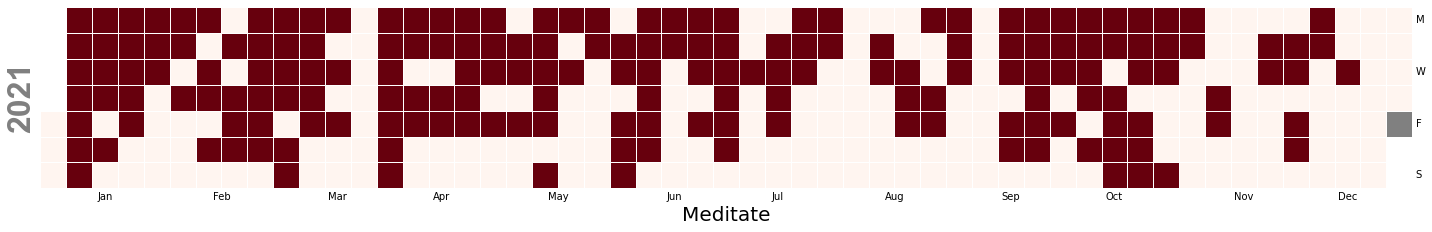

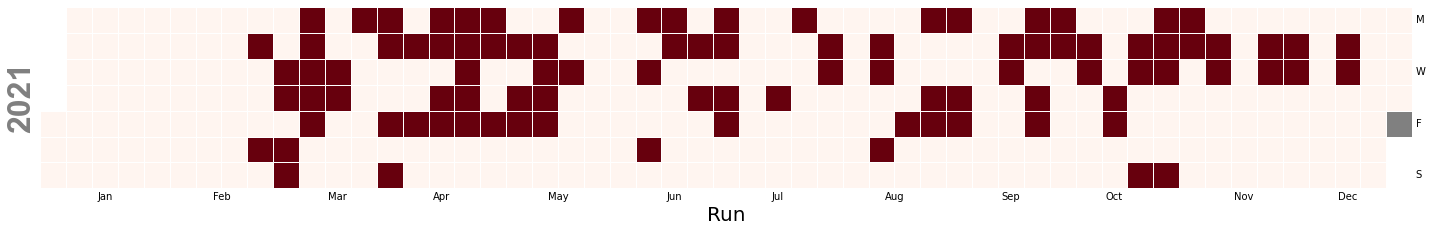

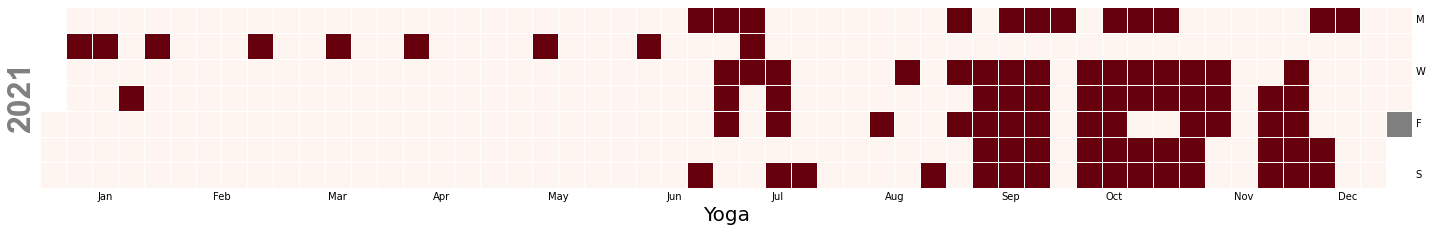

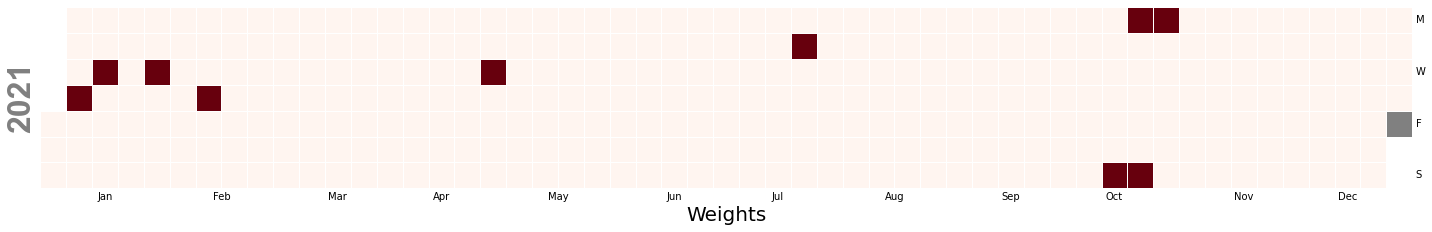

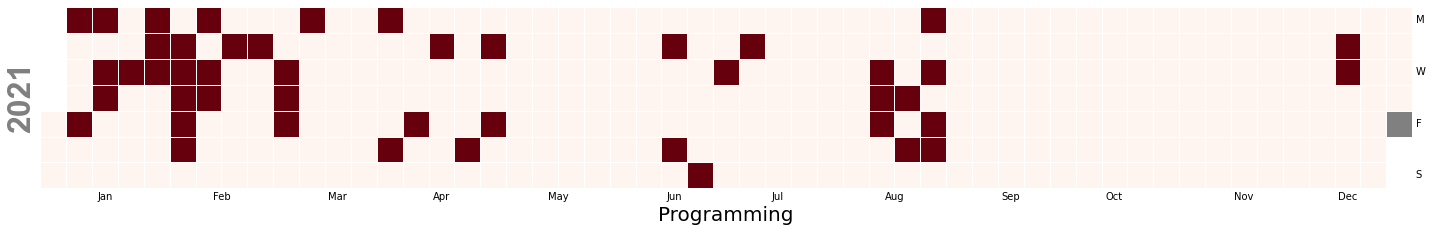

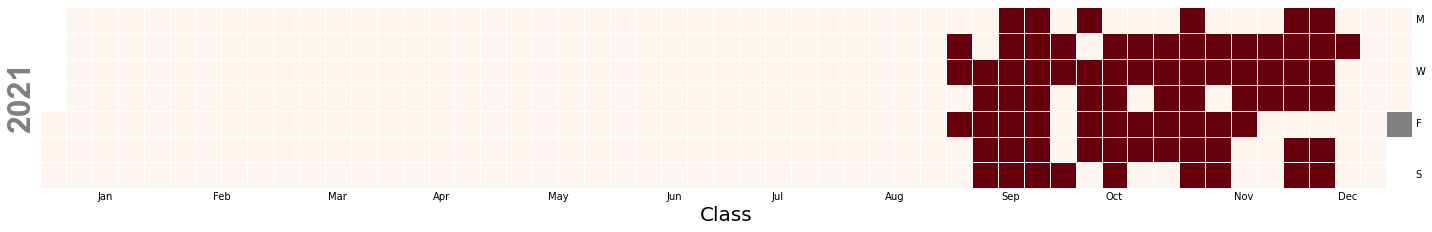

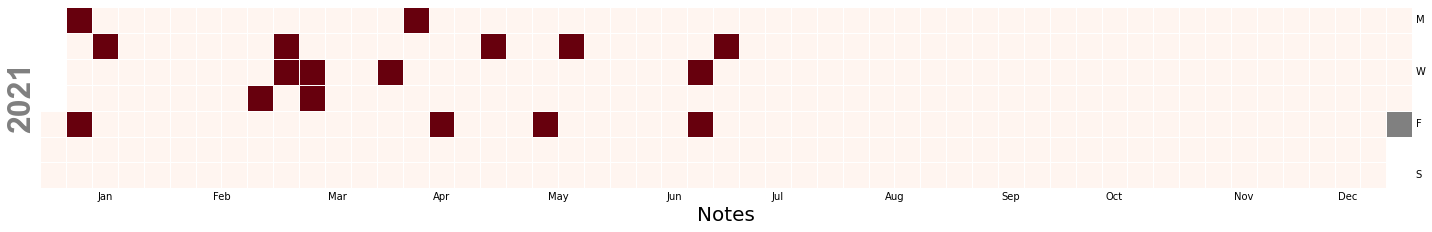

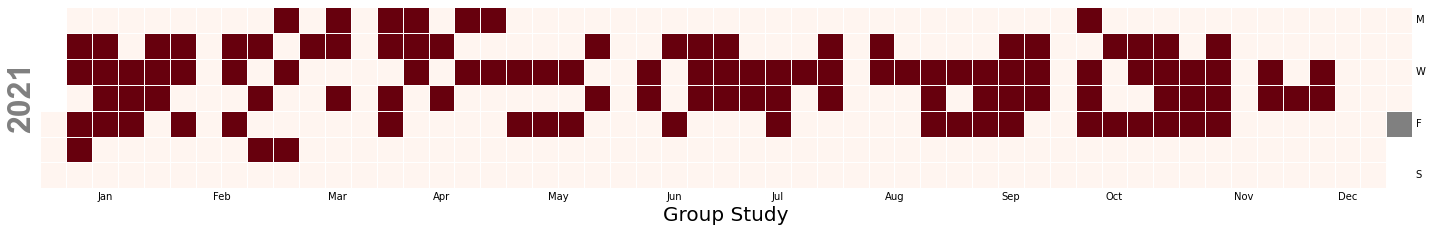

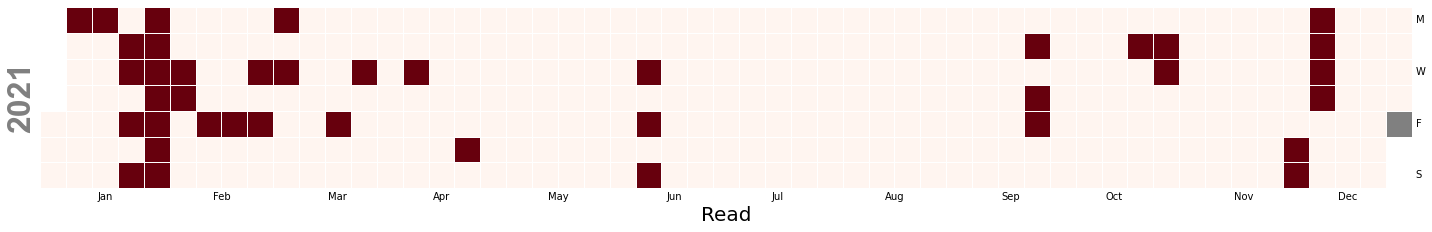

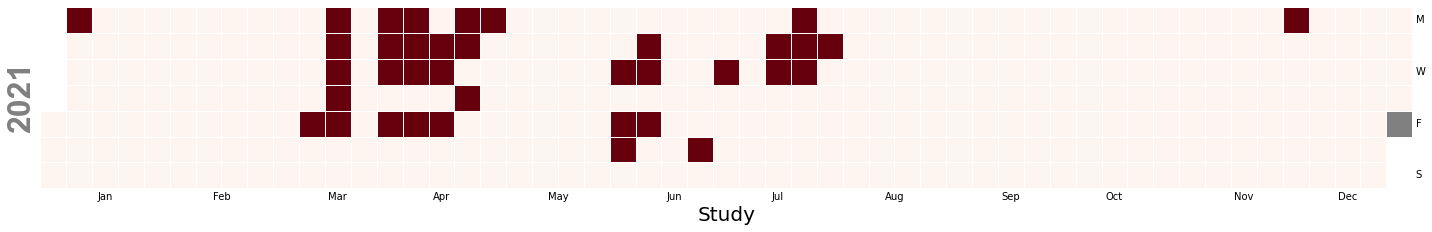

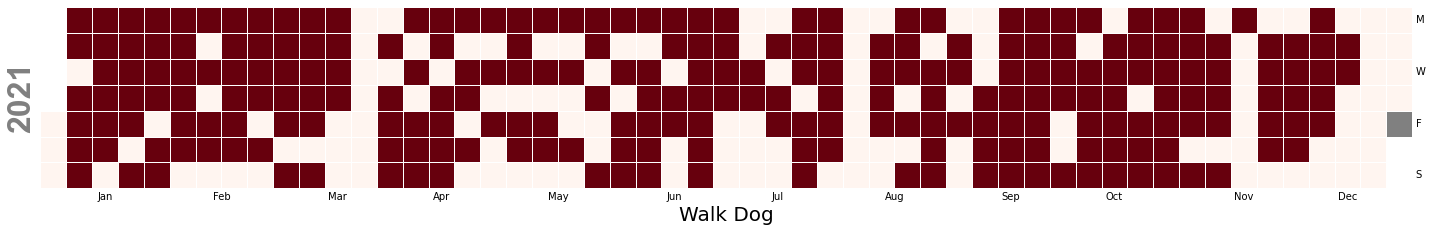

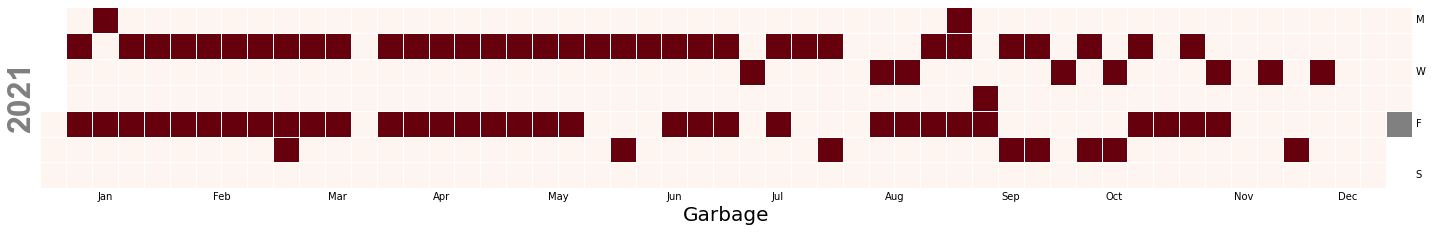

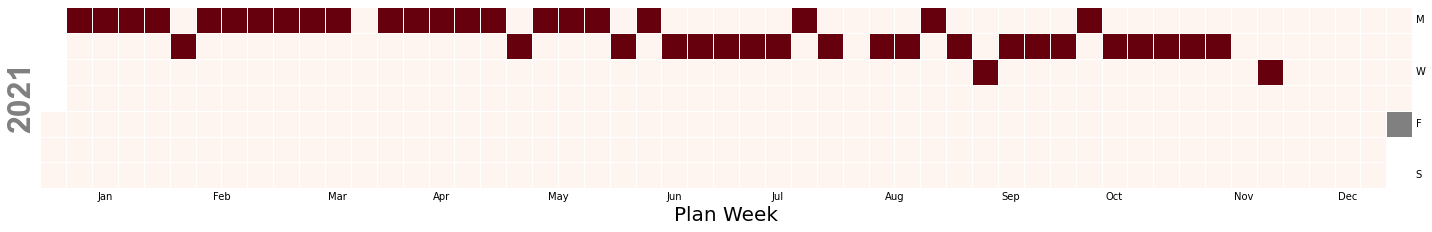

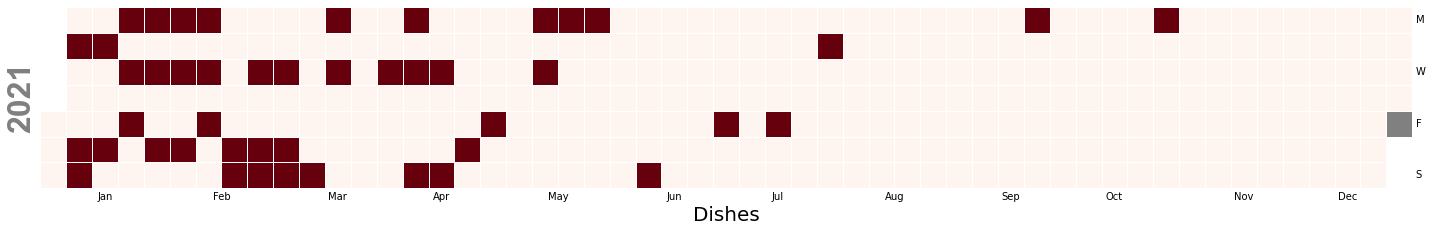

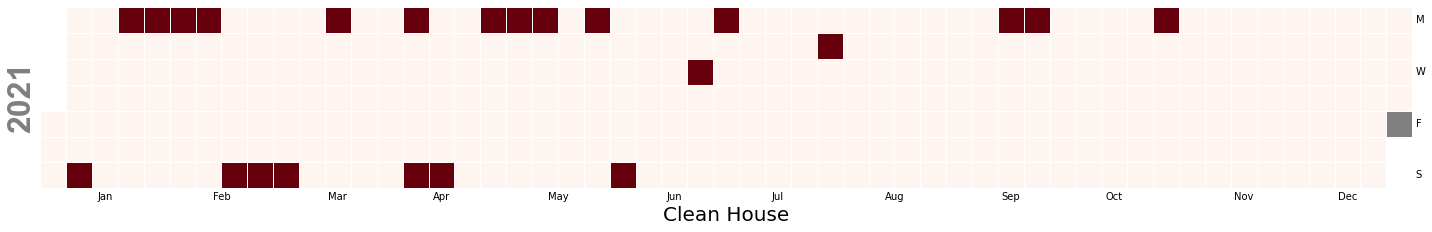

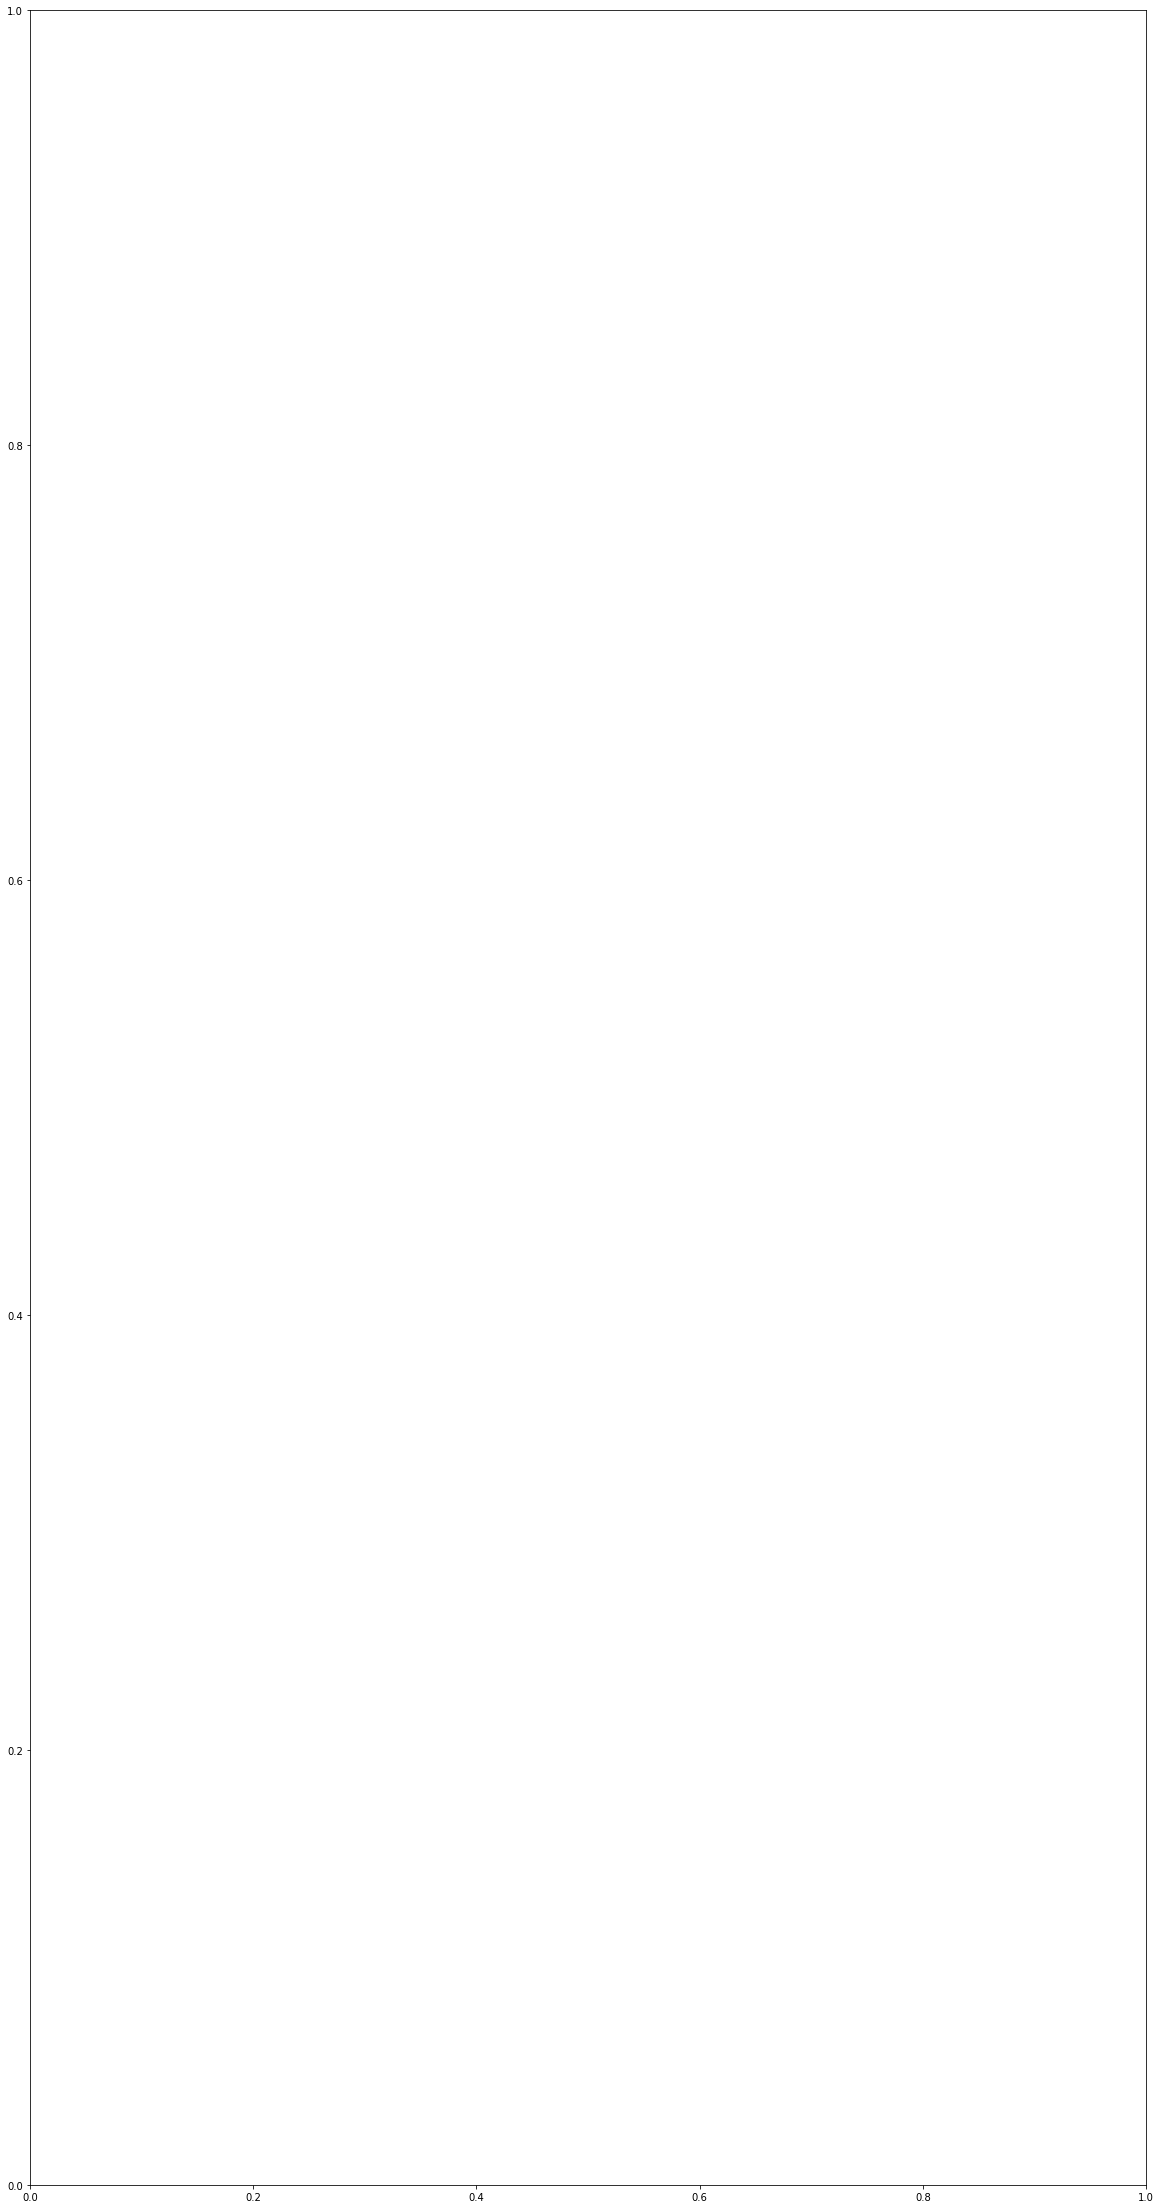

In [870]:
for habit in cal_df.columns:
    ax = calmap.calendarplot(cal_df[habit], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    fillcolor='grey', linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
    ax[1][0].set_xlabel(habit, fontsize=20)



Text(0.5, 300.0811320754717, 'Yoga')

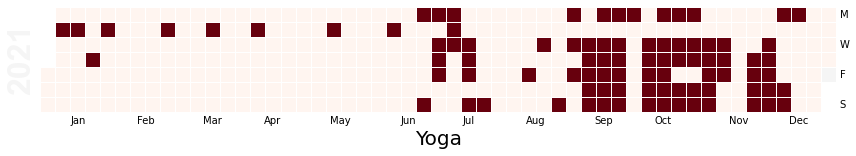

In [865]:
ax = calmap.calendarplot(cal_df["Yoga"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(12, 10)))
ax[1][0].set_xlabel("Yoga", fontsize=20)


Text(0.5, 300.0811320754717, 'Run')

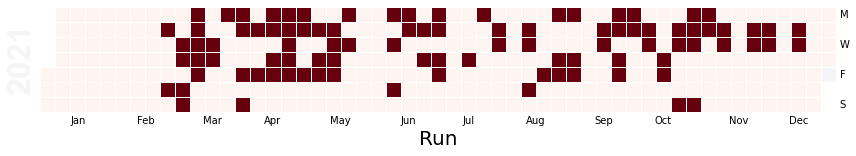

In [872]:
ax = calmap.calendarplot(cal_df["Run"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(12, 10)))
ax[1][0].set_xlabel("Run", fontsize=20)

Text(0.5, 300.0811320754717, 'Weights')

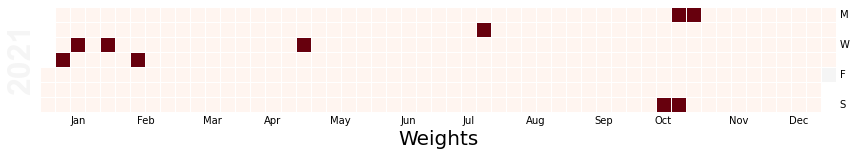

In [874]:
ax = calmap.calendarplot(cal_df["Weights"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(12, 10)))
ax[1][0].set_xlabel("Weights", fontsize=20)

Text(0.5, 1356.0018867924528, 'Meditate')

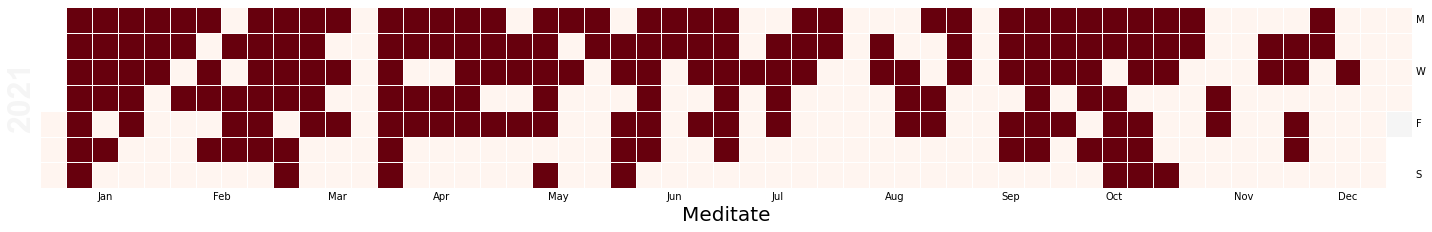

In [876]:
ax = calmap.calendarplot(cal_df["Meditate"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
ax[1][0].set_xlabel("Meditate", fontsize=20)


Text(0.5, 1356.0018867924528, 'Group Study')

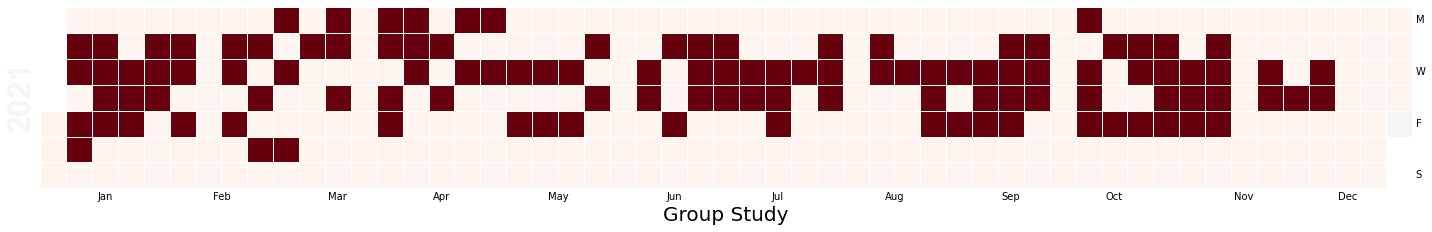

In [877]:
ax = calmap.calendarplot(cal_df["Group Study"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
ax[1][0].set_xlabel("Group Study", fontsize=20)


Text(0.5, 1356.0018867924528, 'Class')

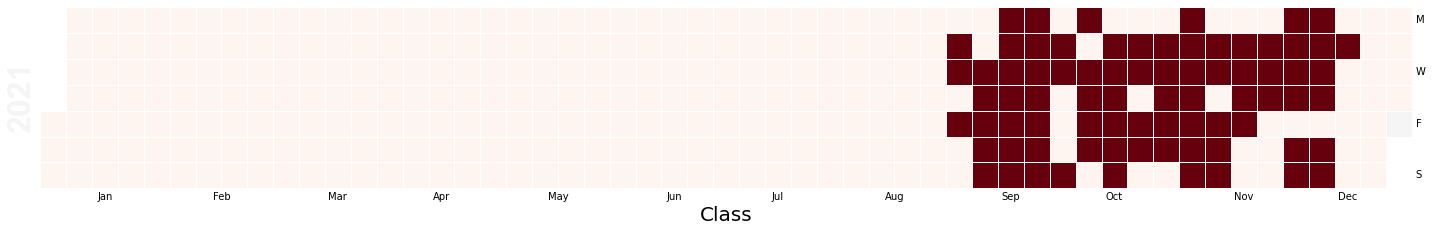

In [878]:
ax = calmap.calendarplot(cal_df["Class"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
ax[1][0].set_xlabel("Class", fontsize=20)

Text(0.5, 1356.0018867924528, 'Programming')

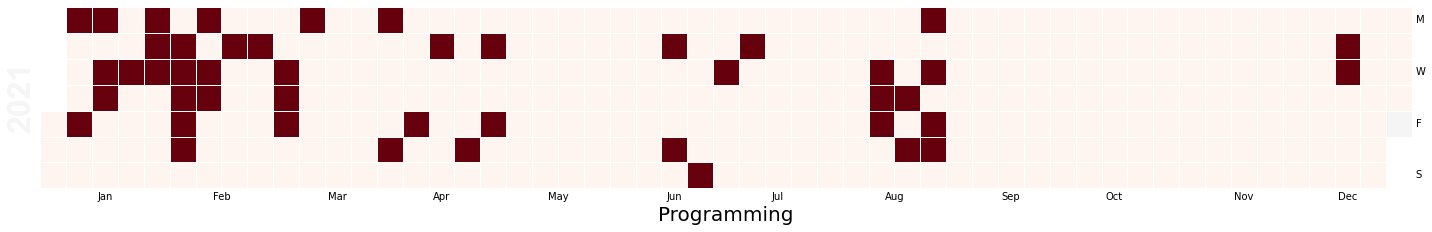

In [879]:
ax = calmap.calendarplot(cal_df["Programming"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
ax[1][0].set_xlabel("Programming", fontsize=20)

Text(0.5, 1356.0018867924528, 'Reading')

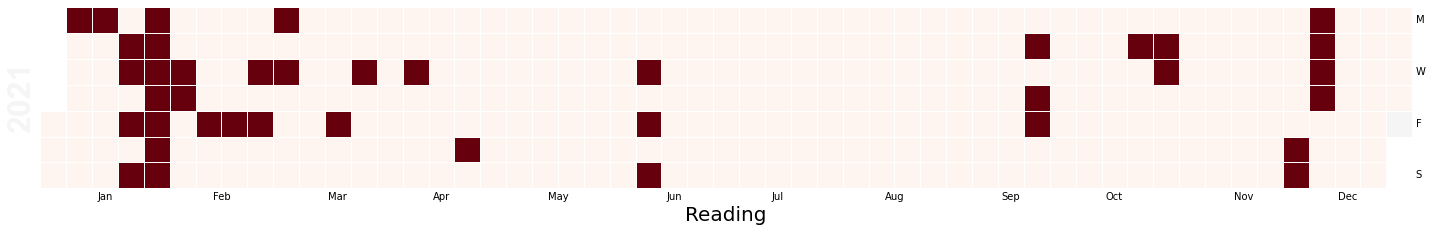

In [880]:
ax = calmap.calendarplot(cal_df["Read"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(20, 40)))
ax[1][0].set_xlabel("Reading", fontsize=20)

# Meditation

In [740]:
meditation.head(4)
medtation_no_theory = meditation[(meditation["type"].str.contains("Daily")) | (meditation["type"].str.contains("Self"))]
medtation_no_theory.duration = meditation.duration.astype(int)
medtation_no_theory = medtation_no_theory.sort_values(by=["date"])
medtation_no_theory = medtation_no_theory.drop_duplicates()
medtation_no_theory

C:\Users\zeusg\Envs\habit\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date  duration              type
442  2021-01-04        20  Daily Meditation
439  2021-01-05        20  Daily Meditation
436  2021-01-06        10  Daily Meditation
433  2021-01-07        20  Daily Meditation
430  2021-01-08        20  Daily Meditation
..          ...       ...               ...
4    2021-10-25        20  Daily Meditation
3    2021-10-26        11        Self Timer
2    2021-10-31        11        Self Timer
1    2021-11-01        11        Self Timer
0    2021-12-06        11  Daily Meditation

[114 rows x 3 columns]

In [741]:
daily = medtation_no_theory[medtation_no_theory["type"].str.contains("Daily")].duration.sum()
self = medtation_no_theory[medtation_no_theory["type"].str.contains("Self")].duration.sum()

In [742]:
self

662

In [781]:
medtation_no_theory[medtation_no_theory.type.str.contains("Self")].count()[0]

56

In [774]:
medtation_no_theory

date  duration              type
442  2021-01-04        20  Daily Meditation
439  2021-01-05        20  Daily Meditation
436  2021-01-06        10  Daily Meditation
433  2021-01-07        20  Daily Meditation
430  2021-01-08        20  Daily Meditation
..          ...       ...               ...
4    2021-10-25        20  Daily Meditation
3    2021-10-26        11        Self Timer
2    2021-10-31        11        Self Timer
1    2021-11-01        11        Self Timer
0    2021-12-06        11  Daily Meditation

[114 rows x 3 columns]

In [1058]:

fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{"colspan": 2}, None],
           [{'type':'domain'}, {}]],
    subplot_titles=("Meditation Practice by type","Time Meditating by Type", "Meditation Duration By Type"))

fig.add_trace(
    go.Bar(
        x =medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["date"],
        y= medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["duration"],
        name = "Self Timer",
        marker_color='Green',
), row=1, col=1)
fig.add_trace(
    go.Bar(
        x = medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["date"],
        y = medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["duration"],
        name = "Guided",
        marker_color='Blue'
), row=1, col=1)
fig.add_trace(
    go.Pie(
        labels=["Self Timer", "Guided"], 
        values = [medtation_no_theory[medtation_no_theory.type.str.contains("Self")].count()[0], medtation_no_theory[medtation_no_theory.type.str.contains("Daily")].count()[0]],
        marker_colors= ['Green', 'Blue'],
        showlegend=False,
), row = 2, col =1)

fig.add_trace(
    go.Histogram(
        x=medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["duration"], 
        showlegend=False,
        marker_color='Green',
        name = "Self Timer"
        
), row = 2, col =2)
fig.add_trace(
    go.Histogram(
        x=medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["duration"], 
        showlegend=False,
        marker_color='Blue',
        name = "Guided"
), row = 2, col =2)

fig.update_layout(
    yaxis=dict(
        title_text="Duration (mins)",
        ),
    xaxis=dict(
        title_text="Date",)
    )
fig['layout']['xaxis']['title']='Date'
fig['layout']['xaxis2']['title']='Time'
fig['layout']['yaxis']['title']='Duration (Mins)'
fig['layout']['yaxis2']['title']='Frequency'
fig.write_html("./webpage/meditationBreakdown.html")
fig.show()

# Education

### Listening Time

In [815]:
audible = 275
podcast = 327 
listening_time = {"Audible":275/24, "Podcast": 327/24}
colors = ['crimson', 'blue']

podcasts = {"Making Sense":54,"Very Bad Wizards":39, "Machine Learning Street Talk": 11, "Decoding the Gurus": 10.5, 
            "Dan Carlins Harcore History": 5.75, "Forward":4, "Searial": 3.75, "Lex Fridman": 3, "Krystal Kyle & Friends": 1.75, 
            "Common Sense with Dan Carlin": 1.5, "Dan Carlins Harcore History Addendum": 1.5, "Sean Carroll's Mindcape": 1, 
            "Econ Talk": 1, "Other": 1}

In [994]:

fig = make_subplots(
    rows = 1, 
    cols=2,
    specs=[[{}, {'type':'domain'}]],
    subplot_titles=("Days Spent Listening","Percent Listening by Source"))
fig.add_trace(go.Bar(
    x = list(listening_time.keys()),
    y = list(listening_time.values()),
    marker_color = colors,
    showlegend=False,
), row=1, col=1)
fig.add_trace(go.Pie(
    labels = list(listening_time.keys()),
    values = list(listening_time.values()),
    marker_colors = colors,

), row=1, col=2)
fig.update_layout(
    title = "Audio Content Consumed",
    yaxis=dict(
        title_text="Days Listening",
        ),
    xaxis=dict(
        title_text="Source",)
    )
fig.write_html("./webpage/listeningBreakdown.html")
fig.show()

In [823]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = list(podcasts.keys()),
        y = list(podcasts.values()),
))
fig.update_layout(
    title = "Podcast Listening Time",
    yaxis=dict(
        title_text="Hours Listening",
        ),
    xaxis=dict(
        title_text="Podcast",)
    )
fig.write_html("./webpage/podcastBreakdown.html")
fig.show()

Coursera Classes

In [985]:
classes ={"Build Basic Generative Adversarial Networks (GANs)":"Jan 04 2021", "Data-driven Astronomy": "Aug 12 2021",
          "Apply Generative Adversarial Networks (GANs)":"Apr 20 2021", "Build Better Generative Adversarial Networks (GANs)":"Apr 08 2021", 
          "Learning How to Learn: Powerful mental tools to help you master tough":"Mar 30 2021",
          "SIADS 532: Data Mining 1":"Dec 20 2021", "SIADS 505: Data Manipulation":"Sept 30 2021", "SIADS 503: Data Science Ethics":"Nov 21 2021","SIADS 521: Visual Exploration of Data":"Nov 21 2021",
          "SIADS 522: Information Visualization I":"Oct 24 2021","SIADS 502: Math Methods for Data Science":"Oct 24 2021","SIADS 501: Being a Data Scientist ":"Sept 30 2021"}

classes

{'Build Basic Generative Adversarial Networks (GANs)': 'Jan 04 2021',
 'Data-driven Astronomy': 'Aug 12 2021',
 'Apply Generative Adversarial Networks (GANs)': 'Apr 20 2021',
 'Build Better Generative Adversarial Networks (GANs)': 'Apr 08 2021',
 'Learning How to Learn: Powerful mental tools to help you master tough': 'Mar 30 2021',
 'SIADS 532: Data Mining 1': 'Dec 20 2021',
 'SIADS 505: Data Manipulation': 'Sept 30 2021',
 'SIADS 503: Data Science Ethics': 'Nov 21 2021',
 'SIADS 521: Visual Exploration of Data': 'Nov 21 2021',
 'SIADS 522: Information Visualization I': 'Oct 24 2021',
 'SIADS 502: Math Methods for Data Science': 'Oct 24 2021',
 'SIADS 501: Being a Data Scientist ': 'Sept 30 2021'}

In [993]:
fig = go.Figure()
fig.add_trace(
    go.Table(
        header=dict(
            values=["Class Name", "Date Completed"],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[list(classes.keys()), list(classes.values())],
            align = "left")
    ),)
fig.write_html("./webpage/classes_taken.html")
fig.show()

In [988]:
[list(classes.keys()), list(classes.values())]

[['Build Basic Generative Adversarial Networks (GANs)',
  'Data-driven Astronomy',
  'Apply Generative Adversarial Networks (GANs)',
  'Build Better Generative Adversarial Networks (GANs)',
  'Learning How to Learn: Powerful mental tools to help you master tough',
  'SIADS 532: Data Mining 1',
  'SIADS 505: Data Manipulation',
  'SIADS 503: Data Science Ethics',
  'SIADS 521: Visual Exploration of Data',
  'SIADS 522: Information Visualization I',
  'SIADS 502: Math Methods for Data Science',
  'SIADS 501: Being a Data Scientist '],
 ['Jan 04 2021',
  'Aug 12 2021',
  'Apr 20 2021',
  'Apr 08 2021',
  'Mar 30 2021',
  'Dec 20 2021',
  'Sept 30 2021',
  'Nov 21 2021',
  'Nov 21 2021',
  'Oct 24 2021',
  'Oct 24 2021',
  'Sept 30 2021']]

# Fitness

### Year to Year comparison 

 https://dev.fitbit.com/build/reference/web-api/activity/get-activity-log-list/

In [195]:
run_21 = fit_21[fit_21["name"] == "Run"]
run_21 = run_21.reset_index()

run_20 = fit_20[fit_20["name"] == "Running"]
run_20 = run_20.reset_index()

run_19 = fit_19[fit_19["name"] == "Running"]
run_19 = run_19.reset_index()

runs = {"2019":run_19,"2020": run_20, "2021":run_21}

yoga_21 = fit_21[fit_21["name"] == "Yoga"]
yoga_21 = yoga_21.reset_index()

yoga_20 = fit_20[fit_20["name"] == "Yoga"]
yoga_20 = yoga_20.reset_index()

yoga_19 = fit_19[(fit_19["name"] == "Yoga") & (fit_19["duration"] < 150)]
yoga_19 = yoga_19.reset_index()

yogas = {"2019":yoga_19,"2020": yoga_20, "2021":yoga_21}

colors = {"2019": "red", "2020": "blue", "2021":"green"}


In [905]:
1.982985/20

0.09914925

In [902]:
runs["2019"]

index        date     name     calories  distance  duration
0       0  2019-03-20  Running    55.829180  0.254063       6.0
1       1  2019-03-29  Running   284.288450  2.168683      22.0
2       2  2019-06-13  Running    12.710435  0.084469       1.0
3       3  2019-06-17  Running    44.960964  0.359655       4.0
4       4  2019-06-23  Running    16.884233  0.059506       1.0
5       5  2019-07-12  Running    32.512830  0.750329       3.0
6       6  2019-07-21  Running   109.325290  0.460726      10.0
7       7  2019-07-25  Running   163.418690  0.696465      15.0
8       8  2019-09-03  Running   125.511920  1.292350       7.0
9       9  2019-09-04  Running   307.906560  1.982985      20.0
10     10  2019-09-05  Running   313.583280  2.025558      20.0
11     11  2019-09-16  Running   151.706600  1.218740      10.0
12     12  2019-09-18  Running   259.917420  1.586810      25.0
13     13  2019-09-19  Running   464.433530  3.170849      32.0
14     14  2019-09-23  Running   309.215500  3.428899      20.0
15     15  2019-10-03  Running   508.000000  3.330713      63.0
16     16  2019-10-07  Running   150.795730  1.045376       9.0
17     17  2019-10-13  Running   171.170800  1.195296       9.0
18     18  2019-10-14  Running   148.918730  1.021819      10.0
19     19  2019-10-16  Running   428.000000  2.890619      65.0
20     20  2019-10-21  Running   105.245290  0.716003       7.0
21     21  2019-10-28  Running   155.899960  1.035678      10.0
22     22  2019-11-18  Running   455.745400  1.591847      47.0
23     23  2019-11-20  Running   353.500520  1.724830      36.0
24     24  2019-11-22  Running  1088.442000  1.271144     112.0
25     25  2019-11-25  Running    52.134174  0.381834       3.0

In [908]:
fig = go.Figure()
for run in runs.keys():
    fig.add_trace(
    go.Histogram(
        x=runs[run]["distance"],
        #histnorm='probability',
        xbins=dict( # bins used for histogram
            start=0,
            end=6.0,
            size=1
        ),
        name = run,
))

fig.update_layout(
    barmode='group',
    bargap=0.3,
    title = "Number of Runs by Miles Ran",
    yaxis=dict(
        title_text="Number of Runs",
    ),
    xaxis=dict(
        title_text="Miles Ran",
        tickmode = 'array',
        tickvals = [.5, 1.5, 2.5, 3.5, 4.5, 5.5],
        ticktext = ['0->1', '1->2', '2->3', '3->4', '4->5', '5->6']
    ),
    )
fig.write_html("./webpage/milesRanYears.html")
fig.show()


In [911]:
fig = go.Figure()
for run in runs.keys():
    fig.add_trace(
        go.Scatter(
            x=runs[run]["date"],
            y=(runs[run]["distance"]/runs[run]["duration"])*60,
            mode='markers',
            name = run,
    ))
fig.update_layout(
    title = "Speed (MPH) of Each Run",
    yaxis=dict(
        title_text="MPH",
    ),
    xaxis=dict(
        title_text="Date",
    ),
    )
fig.write_html("./webpage/MPHYears.html")
fig.show()

In [176]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=("Number Of Runs","Average Distance", "Average Duration", "Average Calories Burnt"))
for run in runs.keys():
    fig.append_trace(go.Bar(
        x=list(run),
        y=[len(runs[run])],
        name = run,
        marker_color = colors[run],
    ), row=1, col=1, )
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].distance.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=1, col=2)
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].duration.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=2, col=1)
    
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].calories.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=2, col=2)

fig.show()

In [209]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=("Days doing Yoga", "Duration", "Average Duration", "Calories Burnt"))
for yoga in yogas:
    fig.append_trace(go.Bar(
        x=list(yoga),
        y=[len(yogas[yoga])],
        name = yoga,
        marker_color = colors[yoga],
    ), row=1, col=1, )
    fig.append_trace(go.Histogram(
        x=yogas[yoga].duration,
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=1, col=2)
    fig.append_trace(go.Bar(
        x=list(yoga),
        y=[yogas[yoga].duration.mean()],
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=2, col=1)
    
    fig.append_trace(go.Histogram(
        x=yogas[yoga].calories,
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=2, col=2)   
fig.show()
    

In [526]:
fit_21

date  name  average_heart_rate  calories  steps  distance  \
312  2021-04-12   Run                 152       156   1618  0.952115   
309  2021-04-13   Run                 151       173   1665  0.999092   
306  2021-04-15   Run                 152       172   1685  1.010471   
303  2021-04-19   Run                 152       159   1669  0.985077   
300  2021-04-20   Run                 161       177   1611  1.012718   
..          ...   ...                 ...       ...    ...       ...   
10   2021-12-05  Yoga                 123       368      0  0.000000   
9    2021-12-05  Yoga                 115       710      0  0.000000   
6    2021-12-11  Yoga                 121       413      0  0.000000   
3    2021-12-12  Yoga                 109       499      0  0.000000   
0    2021-12-14   Run                 154       105   1075  0.654813   

       duration timestamp  
312   12.366667  21:57:27  
309   12.550000  22:16:32  
306   10.650000  22:04:39  
303   12.900000  22:20:00  
300   12.383333  22:02:51  
..          ...       ...  
10    39.533333  14:58:35  
9    106.300000  14:33:03  
6     45.150000  16:32:56  
3     65.300000  14:27:06  
0      7.050000  23:16:22  

[104 rows x 8 columns]

### 2021

In [313]:
a = fit_21.iloc[0]
str(a.date) + " " + str(a["name"])

'2021-04-12 Run'

In [392]:
fit_21.name.unique()

array(['Run', 'Weights', 'Yoga'], dtype=object)

In [444]:
workout_hrs = {"Run":[], "Yoga":[], "Weights":[]}

for workout in workout_hrs.keys():
    for _, hr in fit_21[fit_21.name==workout].iterrows():
        workout_hrs[workout].extend(list(fit_heart_rates[str(hr.date) + " " + str(hr["name"])]["bpm"]))


In [849]:
fig = go.Figure()
for workout in workout_hrs.keys():
    fig.add_trace(
        go.Violin(
            y = workout_hrs[workout],
            name = workout,
        )
    )
fig.update_layout(
    violinmode='overlay', 
    title = "Heart Rate Distribution of Workouts",
    yaxis=dict(
        title_text="% of exercise at Heart Rate (BPM)",
    ),
    )
fig.write_html("./webpage/exerciseHeartRates.html")
fig.show()

In [446]:
ls = np.linspace(0, 1, len(workout_hrs["Run"]))

run_quantiles = quantile(workout_hrs["Run"], ls)
yoga_quantiles = quantile(workout_hrs["Yoga"], ls)
weights_quantiles = quantile(workout_hrs["Weights"], ls)


In [447]:
fig = make_subplots(
    rows=3, cols=3,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{"colspan": 2}, None,None],
           [{"colspan": 2, "rowspan": 2}, None, {"rowspan": 2}],[None,None,None]],
    subplot_titles=("Running Heart Rate","Running HR VS Yoga HR", "Yoga HR"))
fig.add_trace(
    go.Histogram(
        x = run_quantiles,
        name = "Running Heart Rate",
        histnorm='probability',
    ), row=1, col=1)
fig.update_xaxes(range=[50, 190], row=1, col=1)
fig.add_trace(
    go.Scatter(
        x = run_quantiles,
        y = yoga_quantiles,
        
    ), row=2, col=1)
fig.add_trace(
    go.Scatter(
        x = run_quantiles,
        y = run_quantiles,
        
    ), row=2, col=1)
fig.update_xaxes(range=[50, 190], row=2, col=1)
fig.update_yaxes(range=[50, 190], row=2, col=1)

fig.add_trace(
    go.Histogram(
        y = weights_quantiles,
        histnorm='probability',
    ), row=2, col=3)
fig.update_yaxes(range=[50, 190], row=2, col=3)


In [533]:
fit_21
fit_21[(fit_21["name"]=="Run")]

date name  average_heart_rate  calories  steps  distance  \
312  2021-04-12  Run                 152       156   1618  0.952115   
309  2021-04-13  Run                 151       173   1665  0.999092   
306  2021-04-15  Run                 152       172   1685  1.010471   
303  2021-04-19  Run                 152       159   1669  0.985077   
300  2021-04-20  Run                 161       177   1611  1.012718   
297  2021-04-22  Run                 165       164   1579  0.959072   
294  2021-04-26  Run                 159       147   1398  0.843074   
291  2021-04-27  Run                 161       166   1566  0.998592   
285  2021-04-30  Run                 158       158   1625  1.001732   
282  2021-05-04  Run                 157       178   1698  1.100356   
279  2021-05-06  Run                 162       189   1782  1.022510   
274  2021-05-11  Run                 165       165   1535  0.948470   
267  2021-05-17  Run                 153       153   1465  1.052636   
264  2021-05-19  Run                 159       257   2136  1.241635   
261  2021-06-07  Run                 166       188   1613  0.986082   
255  2021-06-09  Run                 161       114   1086  0.628818   
252  2021-06-14  Run                 156       155   1620  1.015247   
246  2021-06-22  Run                 158       267   2324  1.422188   
243  2021-06-24  Run                 166       315   2848  1.720319   
237  2021-06-28  Run                 159       166   1602  1.018844   
231  2021-07-01  Run                 153       140   1337  0.850113   
216  2021-07-15  Run                 155       161   1675  0.997941   
207  2021-07-19  Run                 154       173   1662  0.981829   
198  2021-07-27  Run                 161       170   1706  1.032694   
195  2021-08-10  Run                 161       146   1271  0.733659   
189  2021-08-14  Run                 163       740   6397  3.563753   
183  2021-08-20  Run                 168       207   1812  1.034214   
180  2021-08-23  Run                 161       241   2210  1.294578   
177  2021-08-26  Run                 161       196   1776  1.056000   
171  2021-08-30  Run                 167       189   1720  1.009354   
165  2021-09-02  Run                 170       241   2111  1.162867   
150  2021-09-14  Run                 165       267   2331  1.401707   
138  2021-09-20  Run                 162       169   1581  0.951358   
132  2021-09-23  Run                 155       220   1969  1.216936   
120  2021-09-27  Run                 161       184   1754  1.021126   
117  2021-10-05  Run                 161       274   2429  1.475062   
102  2021-10-14  Run                 170       173   1563  1.051573   
87   2021-10-19  Run                 167       186   1677  1.004563   
77   2021-10-24  Run                 155       218   2151  1.286636   
69   2021-10-26  Run                 161       283   2524  1.452611   
60   2021-10-31  Run                 163       261   2418  1.399691   
57   2021-11-01  Run                 153       164   1698  1.022738   
45   2021-11-09  Run                 162       182   1710  1.012170   
36   2021-11-23  Run                 163       191   1794  1.027204   
24   2021-11-30  Run                 160       265   2594  1.502742   
0    2021-12-14  Run                 154       105   1075  0.654813   

      duration timestamp  
312  12.366667  21:57:27  
309  12.550000  22:16:32  
306  10.650000  22:04:39  
303  12.900000  22:20:00  
300  12.383333  22:02:51  
297  12.216667  22:26:48  
294  11.150000  22:37:31  
291  13.333333  22:06:25  
285  12.533333  21:44:32  
282  13.016667  22:32:15  
279  13.666667  22:24:04  
274  11.900000  22:30:30  
267  11.700000  22:15:33  
264  17.700000  21:56:33  
261  14.716667  22:00:37  
255   7.216667  21:41:23  
252  10.250000  21:51:38  
246  16.100000  21:57:08  
243  18.200000  21:38:43  
237  10.166667  21:49:19  
231   8.433333  21:48:39  
216  10.583333  22:10:21  
207  10.716667  21:50:46  
198  10.900000  22:19:01 

In [473]:
fig = make_subplots(rows = 3, cols =1, shared_xaxes=True,  vertical_spacing=.01)
exercises = ["Yoga", "Weights", "Run"]
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Histogram(
            x = fit_21[fit_21["name"] == exercise]["calories"],
            histnorm='probability',
            name = exercise,
            xbins=dict( # bins used for histogram
                start=-0,
                end=800,
                size=30),
            
    ),row =i+1, col=1) 
    fig.update_xaxes(range=[0, 800], row =i+1, col=1)
fig.show()

In [536]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["calories"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [535]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["duration"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [537]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["calories"]/fit_21[fit_21["name"] == exercise]["duration"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [840]:
colors = ["blue", "red", "green"]
fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{}, {}],[{"colspan": 2}, None]],
    subplot_titles=("Calories Burned By Workout","Duration of Workout", "Calories Burned Per Min by Workout"))
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["calories"], 
            name = exercise,
            line_color=colors[i],
            legendgroup = i,
        ),row = 1, col=1)
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["duration"], 
            name = exercise,
            line_color=colors[i],
            showlegend = False,
            legendgroup = i,
        ),row=1,col=2)
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["calories"]/fit_21[fit_21["name"] == exercise]["duration"], 
            name = exercise,
            line_color=colors[i],
            showlegend = False,
            legendgroup = i,
        ), row=2, col=1)

fig['layout']['xaxis']['title']='Caloreies'
fig['layout']['xaxis2']['title']='Minutes'
fig['layout']['xaxis3']['title']='Calories Per Min'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig['layout']['yaxis3']['title']='Frequency'
fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.write_html("./webpage/exerciseCalories.html")
fig.show()



https://www.freecodecamp.org/news/how-i-analyzed-the-data-from-my-fitbit-to-improve-my-overall-health-a2e36426d8f9/

https://takuti.me/note/first-vis-with-fitbit/

http://www.markwk.com/qs-ledger-intro.html

1. Cals burn per min, per exercise
2. Day of week vs steps ect..
3. Gaps


['Run', 'Weights', 'Yoga']